# Education ...

Project descriptions

## Step 1: Loading and exploring the dataset

In [305]:
import pandas as pd
# read in the mathematics dataset
maths_df = pd.read_csv("student-mat.csv", sep=";")


## Step 2: Pre-processing

In [306]:
# Check for missing values
print(maths_df.isnull().values.any())

False


G3 (final year grade) was calculated using G1 and G2 (1st and 2nd period grades). We will use G3 as the responce variable and later on as the class variable by converitng it to a discrete scale. Since G3 is correlated with G1 and G2, the period grade variables will not be used as predictors in this analysis.

About categorical/numeric...

In [446]:
# Remove G1 and G2 
df = maths_df.drop(['G1', 'G2'], axis = 1)

#df.info()
#<-------------------- Convert grade to a discrete scale ---------------------->#
# Conversion intervals based on Portugal's grade classification system


'''
conditions = [
    (df['G3'] >= 0) & (df['G3'] < 7),
    (df['G3'] >= 7) & (df['G3'] < 10),
    (df['G3'] >= 10) & (df['G3'] < 14),
    (df['G3'] >= 14) & (df['G3'] < 16),
    (df['G3'] >= 16) & (df['G3'] < 18),
    (df['G3'] >= 18) & (df['G3'] <= 20)
]
choices = ['very poor', 'poor', 'sufficient', 'good', 'very good', 'excellent']
'''

# a less fragmented classification with groups lumped together

conditions = [
    (df['G3'] >= 0) & (df['G3'] < 10),
    (df['G3'] >= 10) & (df['G3'] < 16),
    (df['G3'] >= 16) & (df['G3'] <= 20),
]

choices = ['very poor to poor', 'sufficient to good', 'very good to excellent']


# corresponding grade classifications

df['G3_discrete'] = np.select(conditions, choices)

conditions_binary = [
    (df_discrete['G3'] >= 0) & (df_discrete['G3'] < 10),
    (df_discrete['G3'] >= 10) & (df_discrete['G3'] <= 20),
]

choices_binary = ['fail', 'pass']
df['G3_binary'] = np.select(conditions_binary, choices_binary)

# No longer need numeric grade column
#df = df.drop('G3', axis=1)

#<-------------------- Change labels to numeric values ---------------------->#

# Some categorical variables are already encoded with numbers (e.g. studytime 0-4), we need to encode the rest
# df.info()
attributes = list(df)
labels = [a for a in attributes if a not in ('age', 'absences', 'G3')]

# object-type attributes are strings - we need to recode these
#labels = df.select_dtypes(include = "object").columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for l in labels:
    df[l] = le.fit_transform(df[l].astype(str))
#print(df.head())

#<-------------------- Treat ordinal attributes as categorical, not numeric ---------------------->#
'''
# Get column names
attributes = list(df)
# Exclude the attributes that should be treated as numeric
attributes = [a for a in attributes if a not in ('age', 'absences')]
for attribute in attributes:
    df[attribute] = df[attribute].astype('category',copy=False)

    '''


"\n# Get column names\nattributes = list(df)\n# Exclude the attributes that should be treated as numeric\nattributes = [a for a in attributes if a not in ('age', 'absences')]\nfor attribute in attributes:\n    df[attribute] = df[attribute].astype('category',copy=False)\n\n    "

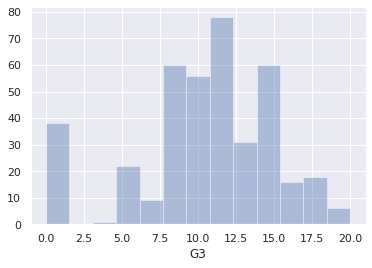

In [447]:
# check if G3 values make sense (are between 0 and 20)
import seaborn as sn
sn.set(color_codes=True)
sn.distplot(df['G3'], kde=False)

# As expected, the grade distribution is approximately bell-curved. 
# The class "sufficient to good" clearly dominates the dataset

# Need to use under-sampling



In [635]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

class_1 = df[df['G3_discrete'] == 1 ] 
class_0 = df[df['G3_discrete'] == 0 ].sample(len(class_1), random_state=42)
class_2 = df[df['G3_discrete'] == 2 ].sample(len(class_1), random_state=42) 
frames = [class_1, class_2, class_0]
balanced_sample = pd.concat(frames)

X = balanced_sample.drop(['G3_discrete','G3_binary', 'G3'], axis=1)
y = balanced_sample['G3_discrete']
selector = SelectKBest(chi2, k=15)
feature_data = selector.fit_transform(X, y)
mask=selector.get_support()
feature_names = X.columns[mask]
df_selected = pd.DataFrame(feature_data, columns=feature_names)

# Now split the data into training and testing (80/20)
train_x, test_x, train_y, test_y = train_test_split(df_selected, y, stratify=y, test_size=0.2, random_state=42)
# no feature selection
# train_x, test_x, train_y, test_y = train_test_split(df.drop(['G3_discrete','G3_binary', 'G3', 'school'], axis=1), df['G3_discrete'],stratify=df['G3_discrete'], test_size=0.2, random_state=42)
#g_class = GaussianNB()

#Train the model using the training sets
#g_class.fit(train_x, train_y)

#Predict the response for test dataset
#pred_y = g_class.predict(test_x)

#cm=metrics.confusion_matrix(test_y,pred_y)
#df_cm = pd.DataFrame(cm, range(6), range(6))

#sn.set(font_scale=1.4) # for label size
#sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

#plt.show()

#np.count_nonzero(pred_y!=test_y)

#sum(train_y==2)



In [636]:
# already installed the package with pip install mixed-naive-bayes
from sklearn.feature_selection import SelectKBest, chi2
from mixed_naive_bayes import MixedNB

indices=[]
attributes = list(train_x)
attributes = [a for a in attributes if a not in ('age', 'absences')]

for attr in attributes:
    indices.append(train_x.columns.get_loc(attr))

clf = MixedNB(categorical_features=indices)

clf.fit(train_x,train_y)
pred = clf.predict(test_x)


cm=metrics.confusion_matrix(test_y,pred)
df_cm = pd.DataFrame(cm, range(3), range(3))

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size


# calculate accuracy of the model
sum(pred==test_y)/len(test_y)

#best

 


[2 5 5 5 5 3 4 4 2 2 5 5 5 5]


IndexError: index 3 is out of bounds for axis 1 with size 3

In [632]:
# selected features
print(df_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 15 columns):
school        120 non-null int64
sex           120 non-null int64
Medu          120 non-null int64
Fedu          120 non-null int64
Mjob          120 non-null int64
Fjob          120 non-null int64
traveltime    120 non-null int64
studytime     120 non-null int64
failures      120 non-null int64
schoolsup     120 non-null int64
paid          120 non-null int64
romantic      120 non-null int64
Dalc          120 non-null int64
Walc          120 non-null int64
absences      120 non-null int64
dtypes: int64(15)
memory usage: 14.1 KB
None


## Clustering